# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### Multiple LLM Backends
LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `text_gen` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python

from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", api_base=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(llm=text_gen)
```

Note that you can set your llm keys as follows

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```

### Summarization Methods 
The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### Caching 
Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.


In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm  

## Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail_Price?

**Visualization:** `histogram of Retail_Price`

**Rationale:** This tells us the range and frequency of car prices in the dataset, which can be useful for understanding the market.



### Goal 1
---
**Question:** How does Engine_Size__l_ relate to Horsepower_HP_?

**Visualization:** `scatter plot of Engine_Size__l_ vs. Horsepower_HP_`

**Rationale:** This visualization can help us understand the relationship between engine size and horsepower, which can be important for car enthusiasts and buyers who are interested in performance.


In [4]:
# goals can also be based on a persona 
persona = "accountant"
personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail Price?

**Visualization:** `Histogram of Retail Price`

**Rationale:** This will show the frequency distribution of the retail prices of cars. This will help the accountant persona to identify the most and least expensive cars in the dataset.



### Goal 1
---
**Question:** What is the relationship between Horsepower and Retail Price?

**Visualization:** `Scatter plot of Horsepower vs Retail Price`

**Rationale:** This will help the accountant persona to understand the relationship between the horsepower and retail price of cars. This will help them to identify if there is a correlation between the two variables and how strong it is.


## Generate Visualizations

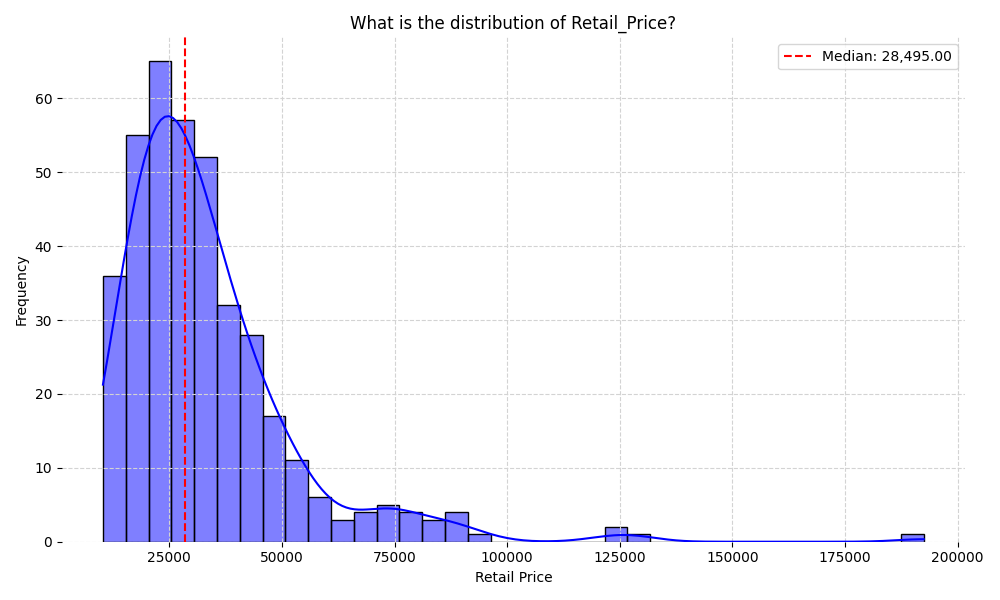

In [5]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

### Generate visualization via a "user query"   

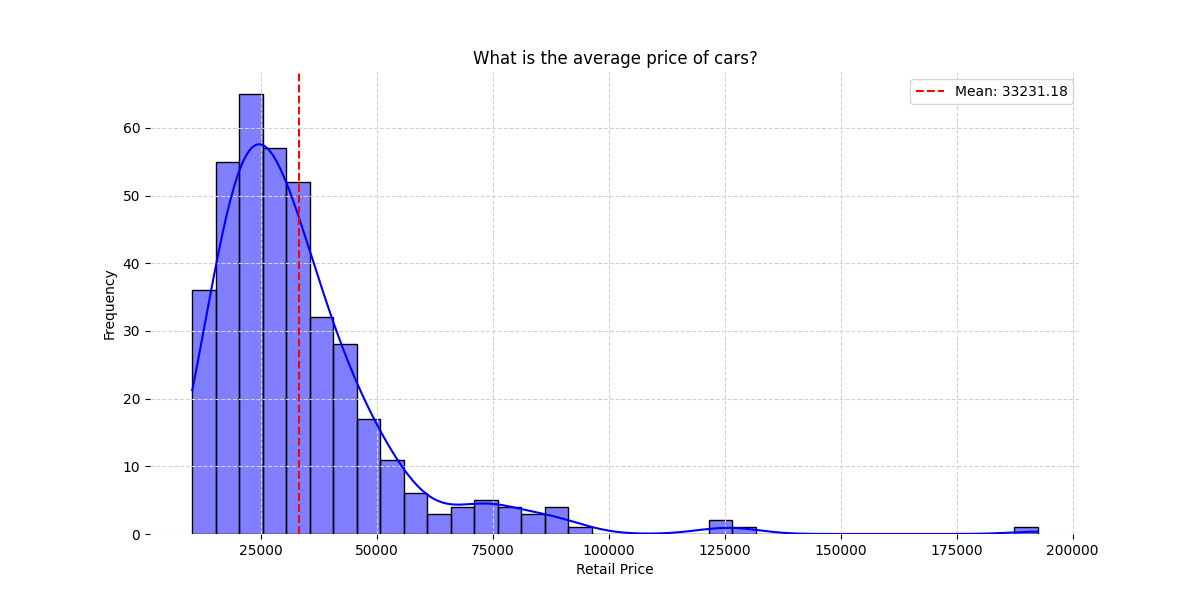

In [6]:
user_query = "What is the average price of cars?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

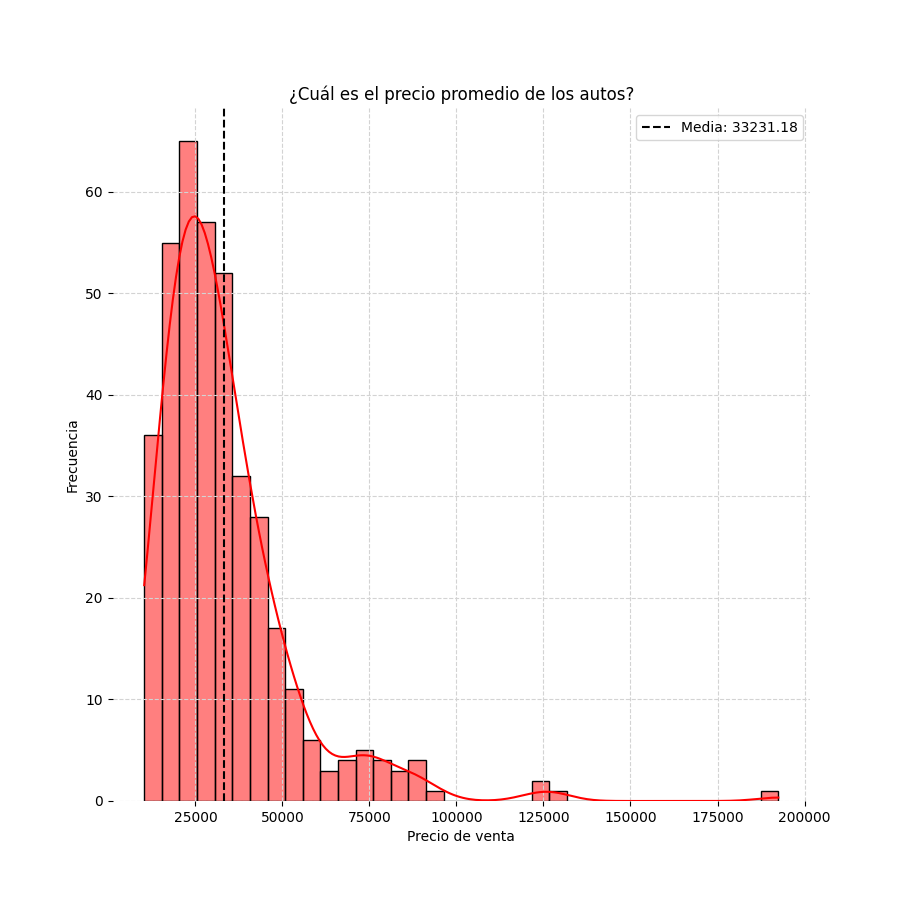

In [7]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["zoom in 50%", "make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [8]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart is a histogram with a blue color and a transparency of 0.5. The chart shows the frequency of retail prices of cars. The red dashed line represents the mean retail price of cars. The chart's title is 'What is the average price of cars?'.
transformation  **  There is no data transformation in this code.
visualization  **  The code first creates a figure with a size of 12 by 6 inches. Then, it creates a histogram using seaborn's histplot function, with the data being the input data, the x-axis being the 'Retail_Price' column, and kde set to True to show the density curve. The histogram is colored blue with a transparency of 0.5. The code then adds a vertical line at the mean of the 'Retail_Price' column, colored red and dashed. The label of the line is set to show the mean value. The legend is added to the chart. The x-axis label is set to 'Retail Price', and the y-axis label is set to 'Frequency'. The chart's title is set to 'What is the average price of cars

## Visualization code self-evaluation and repair

In [9]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, or typos.
	**********************************
transformation Score 10 / 10
	 The data is appropriately filtered and no additional transformation is needed for the histogram.
	**********************************
compliance Score 9 / 10
	 The code meets the specified visualization goal of showing the distribution of Retail_Price. However, the title could be more specific to reflect the goal.
	**********************************
type Score 9 / 10
	 The histogram is an appropriate visualization type for showing the distribution of a continuous variable like Retail_Price. However, a boxplot or violin plot could also be used to show the distributio
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately with Retail_Price on the x-axis.
	**********************************
aesthetics Score 9 / 10
	 The aesthetics of the visualization are appropriate for a histogram. However, the alpha value could

## Visualization Recommendation

In [10]:
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 2 charts


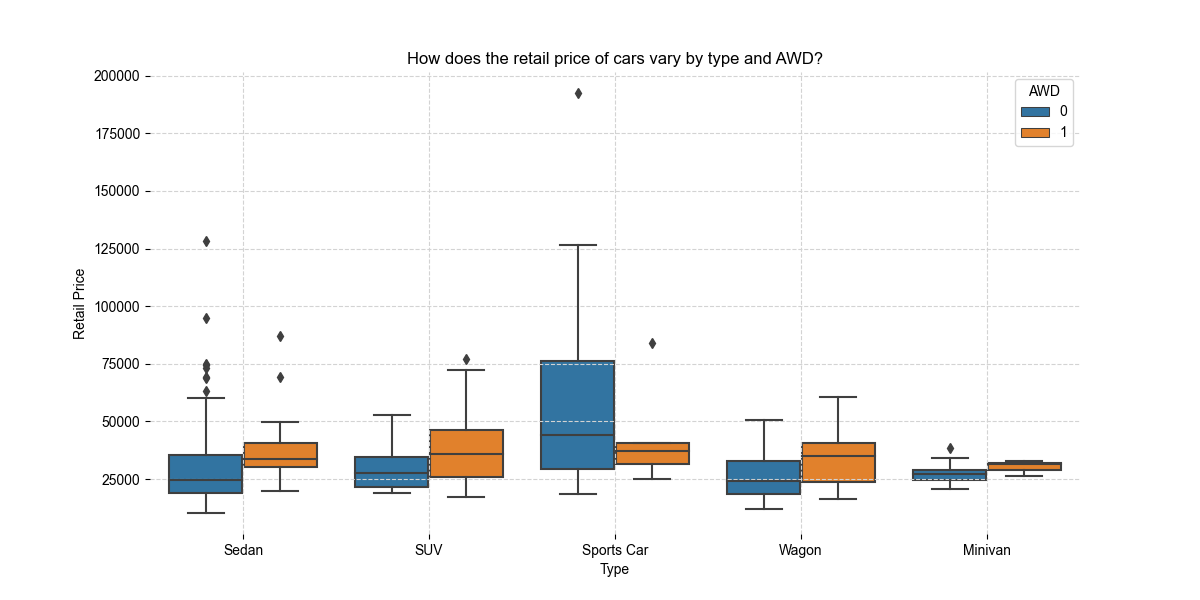

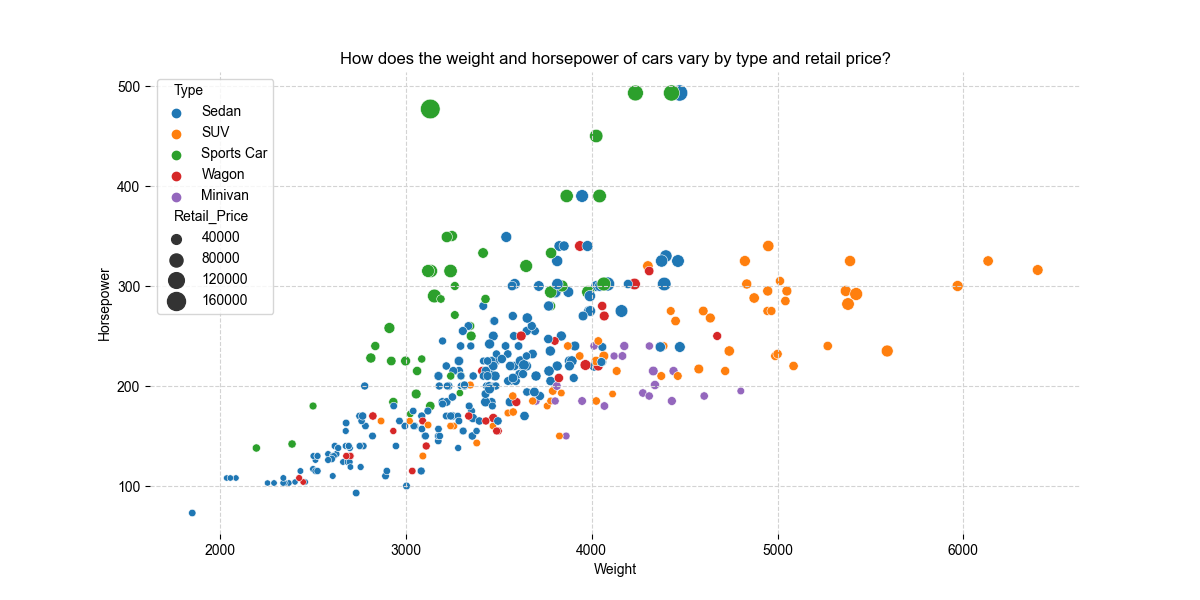

In [11]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [12]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [13]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, rain drops, highly detailed, no blur, white background")

/home/victordibia/miniconda3/envs/coral/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 29 files: 100%|██████████| 29/29 [00:00<00:00, 124243.94it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.71it/s]


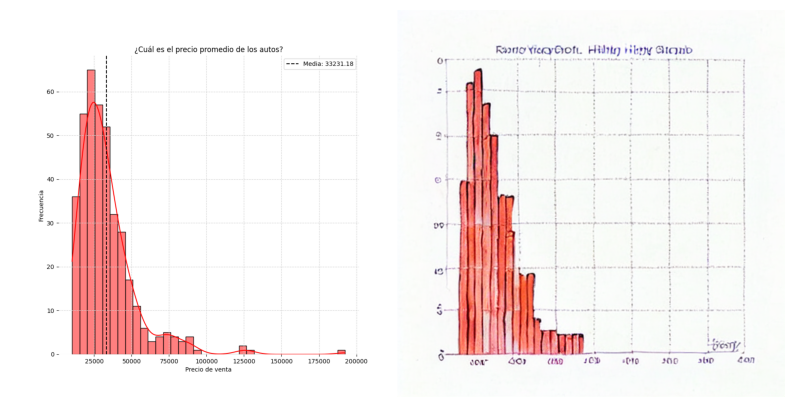

In [14]:
from lida.utils import plot_raster
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 